<a href="https://colab.research.google.com/github/davidzillion/Into_to_tensorflow/blob/main/tf_intro_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Tensorflow

Building a Neural Network to predict fuel efficency (a regression task).

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


In [ ]:
# install if needed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Auto MPG dataset

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()


### Dummify (or One-Hot encode) the "Origin" column

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [ ]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

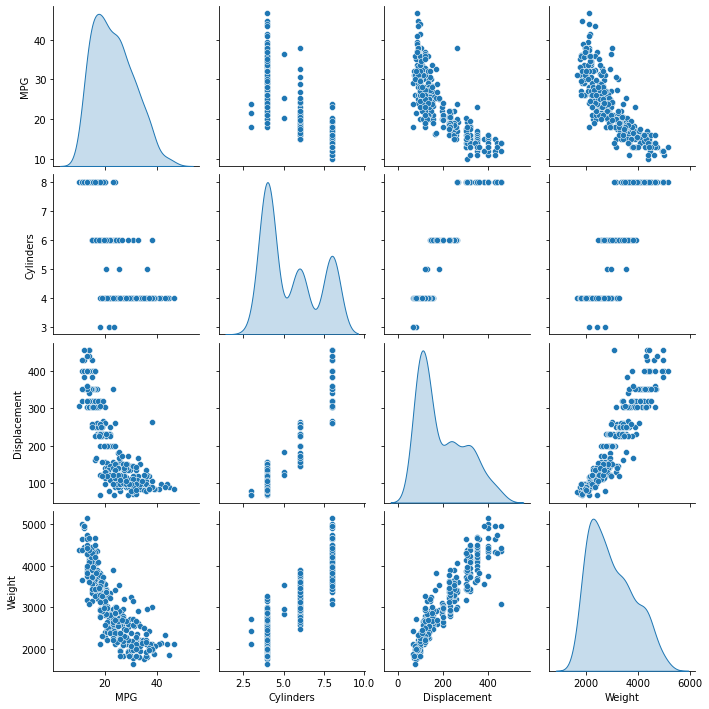

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')


In [ ]:
train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Define features and labels (X and y)

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [ ]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Convert the data to tensors

For now, we will only use a single feature, for now: "Horsepower".

We will use it to predict our train labels.

For the Tensorflow model to be able to "digest" the data, we first need to transform it to "tensors".

In [ ]:
horsepower = tf.convert_to_tensor(train_features['Horsepower'])

target = tf.convert_to_tensor(train_labels)

## Define a simple model

The architecture of your model is defined here. We will always use a Sequential model with Dense layers, but the rest of the parameters can (and should) be tweaked. This is an experimental process, where you need to play around with different layers, units per layer and activation functions. Eventually, you will develop an intuition for what things work better than others.

In [ ]:
simple_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

## Compile the model

Here you define three things:

- **The optimizer**: this is the method that your network will use to update the weights. The Adam optimizer is an “improved” version of the Gradient Descent that you learned in the 3Blue1Brown video series.
- **The learning rate**: this defines how fast or slow we update the weights. It is typically a small value (below 0.5).
- **The loss function**: this is the function that will calculate how well the model is doing. For regression, typical choices include the Mean Squared Error, which can be inputted as the string `mse`, and the Mean Absolute Error, which can be inputed as `mean_absolute_error`.

In [ ]:
simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

## Fit the model

This is the training phase, where the model goes through the data as many times as you define in the `epochs` parameter. Start with a small value, like 10, and check the next step to see whether you need to increase it.

In [ ]:
history = simple_model.fit(
    horsepower, target,
    epochs=100,
    # suppress logging
    verbose=0, # verbose=z1
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

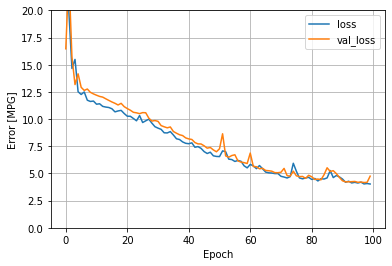

In [ ]:
plot_loss(history) 


In [ ]:
simple_model.evaluate(horsepower, target, verbose=0)

4.346611499786377

## 2nd Iteration: Data Scaling

A neural network can deal with un-scaled data, but when values are big, a small change in the weights of the network can have a big impact on the result. This is the reason why we see such a "bumpy" decline in the loss. Let's scale the data (manually).

In [ ]:
mean = train_features["Horsepower"].mean()
std = train_features["Horsepower"].std()

In [ ]:
horsepower_scaled = (train_features["Horsepower"] - mean) / std

In [ ]:
horsepower_scaled = tf.convert_to_tensor(horsepower_scaled)

In [ ]:
simple_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = simple_model.fit(
    horsepower_scaled, target,
    epochs=50,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

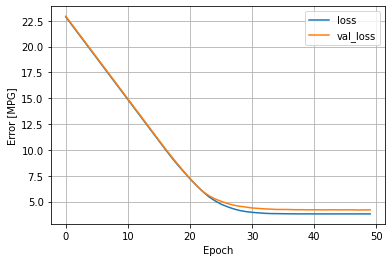

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
simple_model.evaluate(horsepower_scaled, target, verbose=0)

3.8814468383789062

## 3rd Iteration: More layers

You can add as many intermediate ("hidden") layers as you want. Just remember to add a last layer with a single unit, since we only want a single output (the price of a house).

In [ ]:
# Add layers and activation functions here
simple_model = tf.keras.Sequential([
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1)

])

simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

history = simple_model.fit(
    horsepower_scaled, target,
    epochs=20,
    verbose=0,
    validation_split = 0.2)

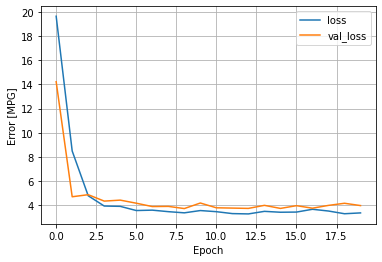

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
simple_model.evaluate(horsepower_scaled, target, verbose=0)

3.3010599613189697

## 4th Iteration: More features

Now that our model is "deep", it should be able to handle more than just one feature.

#### Preprocessing

In [ ]:
# Scaling
mean = train_features.mean()
std = train_features.std()

train_features -= mean # same as train_features = train_features - mean 
train_features /= std

test_features -= mean
test_features /= std

# Data to tensors
train_features_tensor = tf.convert_to_tensor(train_features.values)
test_features_tensor = tf.convert_to_tensor(test_features.values)

train_labels_tensor = tf.convert_to_tensor(train_labels)
test_labels_tensor = tf.convert_to_tensor(test_labels)

#### Modelling

In [ ]:
simple_model = tf.keras.Sequential([
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1)

])

simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.2),
    loss='mean_absolute_error')

history = simple_model.fit(
    train_features_tensor, target, # changed horsepower for train_features_tensor
    epochs=100,
    verbose=0,
    validation_split = 0.2)

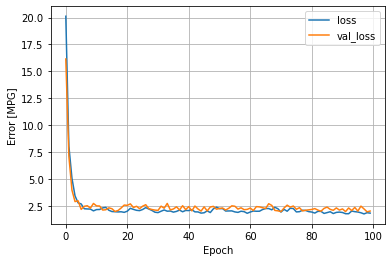

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
simple_model.evaluate(train_features_tensor, train_labels_tensor, verbose=0)

1.901504635810852

In [ ]:
simple_model = tf.keras.Sequential([
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1)

])

simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error')

history = simple_model.fit(
    train_features_tensor, target, # changed horsepower for train_features_tensor
    epochs=5000,
    verbose=0,
    validation_split = 0.2)

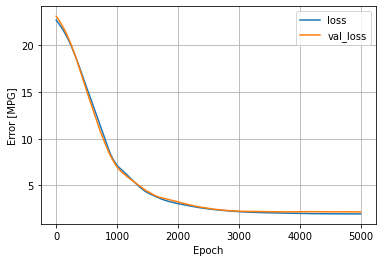

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
simple_model.evaluate(train_features_tensor, train_labels_tensor, verbose=0)

1.9885897636413574

## Check performance on the test set

In [ ]:
from sklearn.metrics import mean_absolute_error
 
predictions = simple_model.predict(test_features_tensor)
mean_absolute_error(test_labels, predictions)

1.791249644450652